# Tarea 1 INF 395

Para las tareas se utilizará `Keras`, una libreria de Deep Learning de alto nivel para Python, con el reciente anuncio de Keras Core, uno puede escoger el backend de su preferencia, ya sea Pytorch, Tensorflow o JAX.

Para más Información pueden revisar la documentación oficial de Keras: https://keras.io/

In [ ]:
#Para utilizar keras-core primero hay que instalar tensorflow o pytorch o jax
#pip install tensorflow 

# una vez instalado nuestro backend podemos instalar keras-core
#Se recomienda correr el jupyter notebook en colab, ya que tiene acceso gratis a GPUS y también tiene ya instalado tensorflow, pytorch y jax, solo hace falta instalar keras-core.
!pip install -q keras-core

## Integrantes:

* Nombre: Joaquín Torres
* Nombre: Lucas Borquez
* Nombre: José Delgado

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

Using TensorFlow backend


## Helper Functions

In [2]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])

In [3]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [4]:
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm).plot()

## Parte 1: Demostración del uso de Keras

### 1.1 Mnist

Mnist es un dataset de imágenes de dígitos escritos a mano. Cada imagen es de 28x28 pixeles y está en escala de grises. El dataset está dividido en 60.000 imágenes de entrenamiento y 10.000 imágenes de testeo.

In [5]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#### Exploración de los Datos

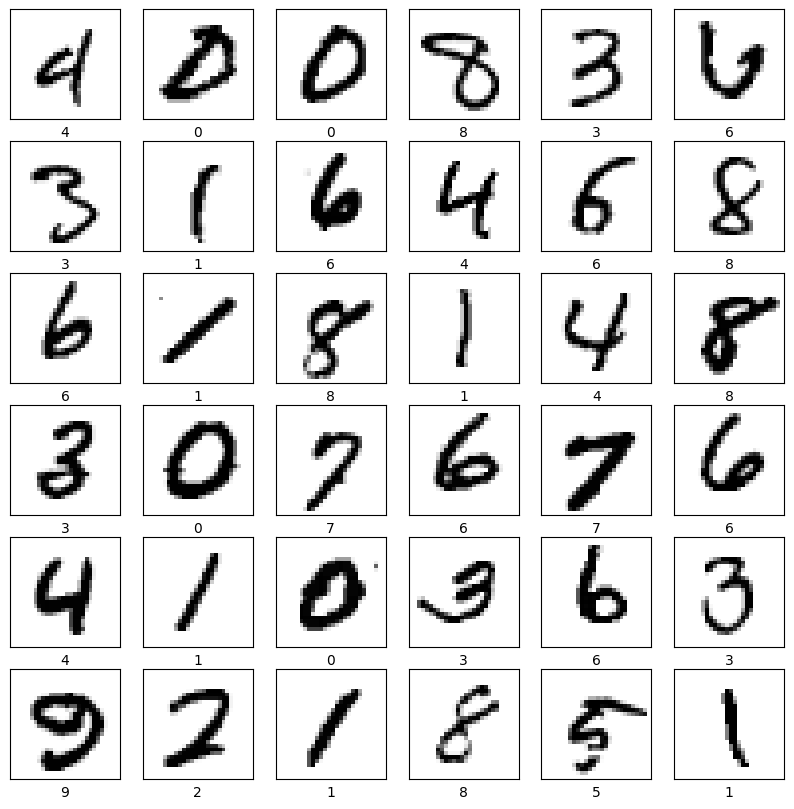

In [6]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [10]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de clases:', num_classes)
print('Dimension de los datos:', input_shape)

cantidad de clases: 10
Dimension de los datos: (28, 28)


#### One Hot Encoding

In [11]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [5 0 4 ... 5 6 8]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


#### Arquitectura de la red

In [12]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

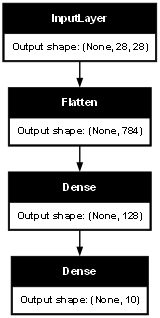

In [13]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

#### Definición de hiperparámetros

In [24]:
# definimos algunos hiperparámetros
batch_size = 128        #cantidad de imágenes por batch
epochs = 20             #cantidad de epochs
validation_split = 0.2  #Porcentaje de data destinada a validación

In [25]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

#### Entrenamiento del Modelo

In [26]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6077 - loss: 17.2967 - val_accuracy: 0.7898 - val_loss: 1.0557
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7962 - loss: 0.9616 - val_accuracy: 0.8378 - val_loss: 0.7853
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8409 - loss: 0.6901 - val_accuracy: 0.8591 - val_loss: 0.6569
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8647 - loss: 0.5500 - val_accuracy: 0.8724 - val_loss: 0.5855
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8799 - loss: 0.4683 - val_accuracy: 0.8839 - val_loss: 0.5360
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8914 - loss: 0.4117 - val_accuracy: 0.8911 - val_loss: 0.5022
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9014 - loss: 0.3691 - val_accuracy: 0.8976 - val_loss: 0.4756
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9085 - loss: 0.3359 - val_accuracy: 0.9021 - val

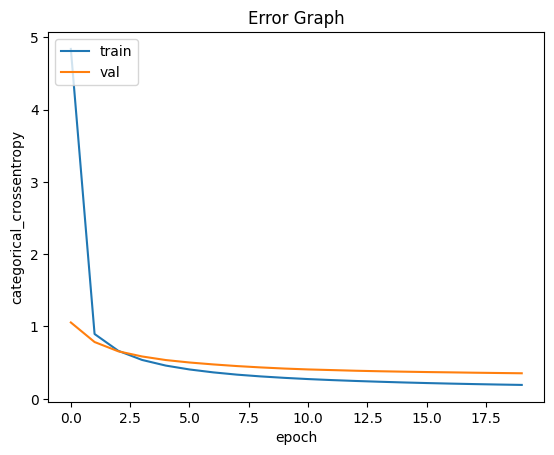

In [27]:
plot_losses(history, loss)

#### Evaluación del Modelo

In [28]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.36804887652397156
Test accuracy: 0.9214000105857849


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


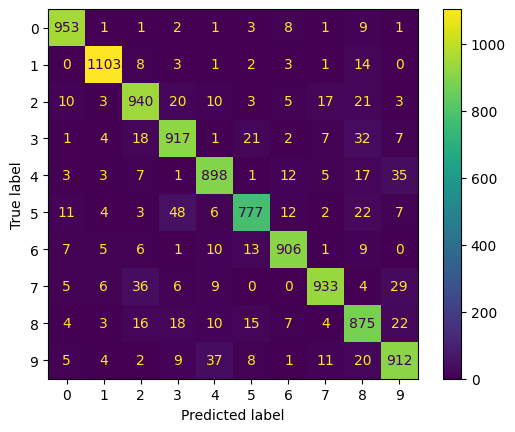

In [29]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

### 1.2.1 Cifar10

Cifar10 es un dataset de imágenes de 32x32 pixeles, que contiene 10 clases distintas. Este dataset es muy utilizado para probar algoritmos de clasificación de imágenes. En este caso, utilizaremos una versión reducida de este dataset, que contiene 50000 imágenes de entrenamiento y 10000 imágenes de testeo, con 100 imágenes por clase. Las clases son: 'avión', 'automóvil', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco' y 'camión'.

In [30]:
#Cargamos el Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


In [31]:
#Visualizamos si el dataset es balanceado o no.
pd.value_counts(pd.Series(y_train.reshape(-1)))

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: count, dtype: int64

c:\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


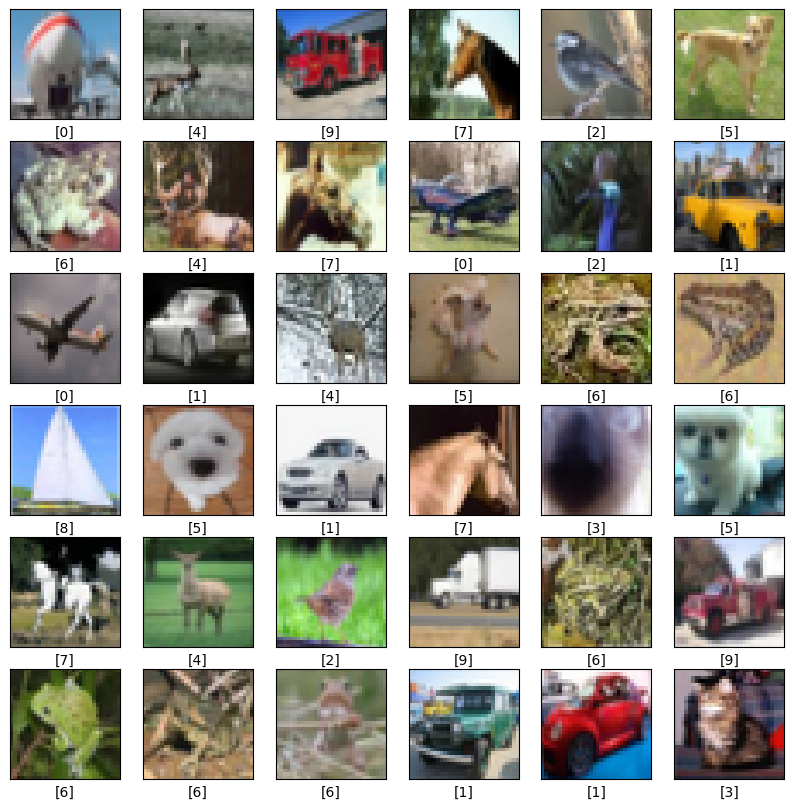

In [46]:
# Visualizamos algunas imágenes y sus clases
viz_imgs(x_train, y_train)

In [47]:
#Descripción de los datos
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print('cantidad de imágenes:',x_train.shape[0])
print('Dimensión de los datos:',input_shape)
print('Tipo de Datos:',x_train.dtype)
print('cantidad de clases:', num_classes)

cantidad de imágenes: 50000
Dimensión de los datos: (32, 32, 3)
Tipo de Datos: uint8
cantidad de clases: 10


In [48]:
# convertimos los vectores de clases a matrices binarias
print('antes:\n',y_train)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nDespues:\n',y_train)

antes:
 [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]

Despues:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [49]:
#Un modelo simple de redes neuronales FeedForward
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │    393,344 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 10)                │      1,290 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

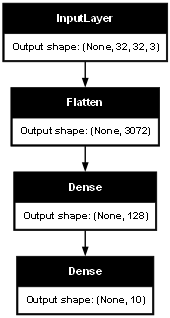

In [50]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [51]:
# definimos algunos hiperparámetros
batch_size = 128 
epochs = 20 
validation_split = 0.2 

In [52]:
#compilamos nuestro modelo, agregando la función de pérdida, el optimizador y las métricas
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.SGD(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [53]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1021 - loss: 582.5864 - val_accuracy: 0.0953 - val_loss: 2.3144
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1018 - loss: 2.3032 - val_accuracy: 0.0953 - val_loss: 2.3126
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1017 - loss: 2.3021 - val_accuracy: 0.0954 - val_loss: 2.3128
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1019 - loss: 2.3018 - val_accuracy: 0.0954 - val_loss: 2.3130
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3131
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 0.0954 - val_loss: 2.3125
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1019 - loss: 2.3017 - val_accuracy: 

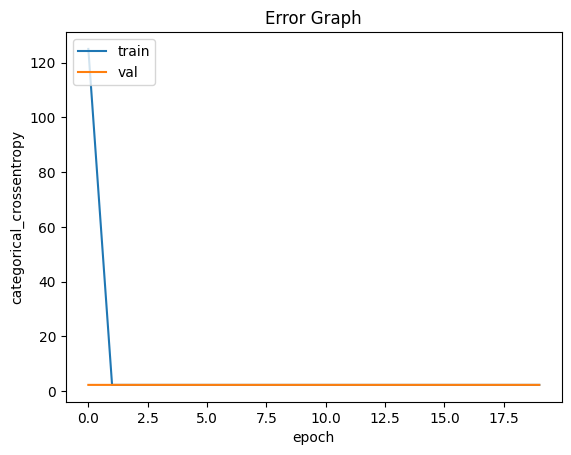

In [54]:
plot_losses(history, loss)

In [55]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.309175729751587
Test accuracy: 0.09969999641180038


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


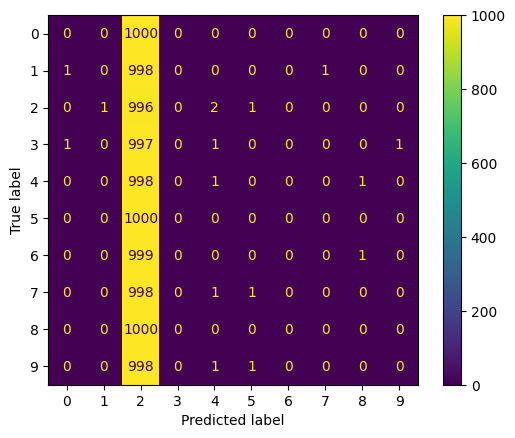

In [56]:
# Graficamos la matriz de confusión
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [57]:
# Comparamos otras métricas de clasificación como la precisión, recall y f1-score
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      1000
     class 1       0.00      0.00      0.00      1000
     class 2       0.10      1.00      0.18      1000
     class 3       0.00      0.00      0.00      1000
     class 4       0.17      0.00      0.00      1000
     class 5       0.00      0.00      0.00      1000
     class 6       0.00      0.00      0.00      1000
     class 7       0.00      0.00      0.00      1000
     class 8       0.00      0.00      0.00      1000
     class 9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.03      0.10      0.02     10000
weighted avg       0.03      0.10      0.02     10000



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podemos observar como este simple modelo de redes neuronales no es lo suficientemente capaz de clasificar las imágenes, de hecho les asigna el mismo label a todas las imágenes.

Es por esto que saltan los warnings, porque al calcular f1, recall y precisión, no hay datos para las otras clases.

Ahora vamos a ver como podemos mejorar nuestro modelo.

### 1.2.2 Mejorando el Modelo

In [58]:
#Es una práctica común en modelos de machine learning escalar nuestros datos, asi nos aseguramos de que todos tengan el mismo rango, con pequeños cambios como estos nuestros modelos pueden mejorar su desempeño.

#Escalamos las imágenes entre [0,1]
x_train = x_train / 255
x_test = x_test / 255

In [59]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x = keras.layers.Flatten()(inputs)
x =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 512)               │  1,573,376 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 10)                │        330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,748,266 (6.67 MB)

 Trainable params: 1,748,266 (6.67 MB)

 Non-trainable params: 0 (0.00 B)

**Explique cómo funciona la capa de Dropout dentro del modelo y por qué esta capa mejora las predicciones [3pts]** 

`Respuesta:` La capa de Dropout es un método de regularización que se utiliza durante el entrenamiento. Básicamente, en cada iteración se sortea aleatoriamente el dropeo de cada nodo con una determinada probabilidad. Esto permite tener mayor redundancia en la determinación del modelo, pues la red debe aprender a predecir una o más características con distintos atributos. En este sentido, Dropout mejora las predicciones debido a que tiene mayor robustez en el análisis. 

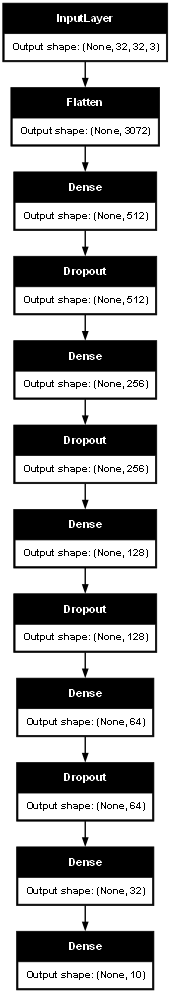

In [60]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [61]:
#Agregamos Callbacks
#Early Stopping monitorea la función de pérdida y detiene el entrenamiento cuando no hay mejora dentro de un número de épocas determinado, lo que nos ahorra tiempo de entrenamiento y también evita el sobreajuste.
my_callbacks = [
    keras.callbacks.EarlyStopping( 
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [62]:
#Cambiamos el Optimizador a Adam
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.Adam(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [63]:
# agregamos más epoochs ahora que tenemos early stopping
batch_size = 128
epochs = 200
validation_split = 0.2

In [64]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.1530 - loss: 2.2533 - val_accuracy: 0.2879 - val_loss: 1.9160
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2859 - loss: 1.9281 - val_accuracy: 0.3340 - val_loss: 1.8416
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3251 - loss: 1.8424 - val_accuracy: 0.3767 - val_loss: 1.7567
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3525 - loss: 1.7783 - val_accuracy: 0.3775 - val_loss: 1.7290
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3692 - loss: 1.7403 - val_accuracy: 0.3817 - val_loss: 1.7021
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3792 - loss: 1.7110 - val_accuracy: 0.4089 - val_loss: 1.6588
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3962 - loss: 1.6793 - val_accuracy: 0.4130 - val_loss: 1.6414
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4079 - loss: 1.6545 - 

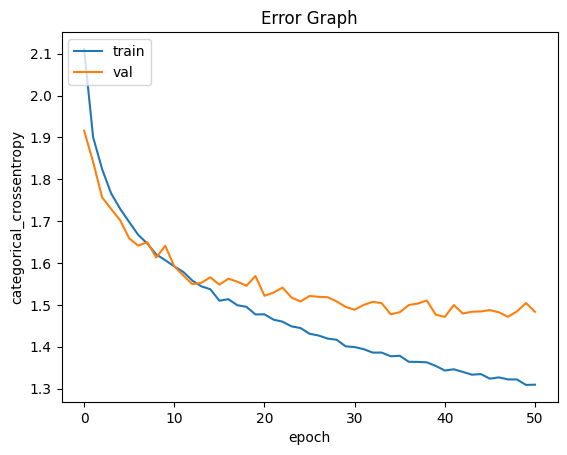

In [65]:
plot_losses(history, loss)

In [66]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4491504430770874
Test accuracy: 0.48820000886917114


Aún estamos con un accuracy del 0.5, eso seria equivalente a lanzar una moneda al aire y que salga cara o sello, por lo que no es un buen modelo, pero se puede mejorar.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


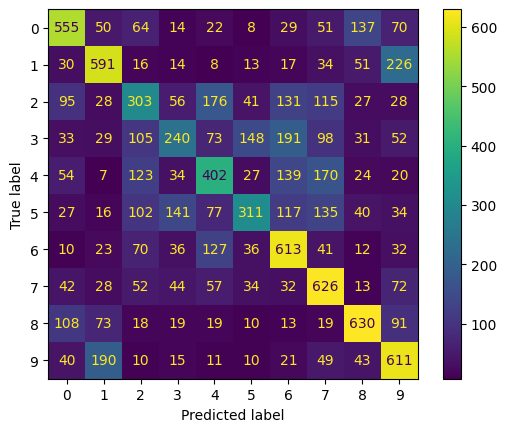

In [67]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [68]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.56      0.56      0.56      1000
     class 1       0.57      0.59      0.58      1000
     class 2       0.35      0.30      0.33      1000
     class 3       0.39      0.24      0.30      1000
     class 4       0.41      0.40      0.41      1000
     class 5       0.49      0.31      0.38      1000
     class 6       0.47      0.61      0.53      1000
     class 7       0.47      0.63      0.54      1000
     class 8       0.62      0.63      0.63      1000
     class 9       0.49      0.61      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000



### 1.2.3 Último Modelo ahora Con Convoluciones y Skip Connections

Keras nos permite complejizar el modelo de una manera muy sencilla, agregaremos capas convolucionales, ya que estas son muy buenas a la hora de trabajar con imágenes, también agregaremos skip connections que son conexiones que se saltan capas del modelo.

**EJEMPLO DE SKIP CONNECTION**

<img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png">

**¿Qué problema resuelven las Skip Connections y como lo hacen? [3pts]**

`Respuesta:` Durante el entrenamiento de redes neuronales profundas el gradiente puede hacerse muy pequeño al realizar el back-propagation, reduciendo su habilidad de aprender. Para resolver este problema, se puede habilitar un camino directo desde el output hacia el input, moviéndose más fácil durante el back-propagation. Esto se llama Skip Connections.

In [69]:
# Agregamos capas de Dropout, inicializadores y hacemos el modelo más profundo
inputs = keras.Input(shape=input_shape)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(inputs)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_1 = keras.layers.BatchNormalization()(x_1)
x_1 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_1)
x_1 = keras.layers.Dropout(0.2)(x_1)
flatten_x1 = keras.layers.Flatten()(x_1)

x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_1)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_2 = keras.layers.BatchNormalization()(x_2)
x_2 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_2)
x_2 = keras.layers.Dropout(0.2)(x_2)
flatten_x2 = keras.layers.Flatten()(x_2)

x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_2)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer="he_normal")(x_3)
x_3 = keras.layers.BatchNormalization()(x_3)
x_3 = keras.layers.MaxPooling2D(pool_size=(2,2))(x_3)
x_3 = keras.layers.Dropout(0.2)(x_3)
flatten_x3 = keras.layers.Flatten()(x_3)

z = keras.layers.concatenate([flatten_x1, flatten_x2])
z = keras.layers.concatenate([z, flatten_x3])

z =  keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal")(z)
z = keras.layers.Dropout(0.1)(z)
z =  keras.layers.Dense(32, activation='relu', kernel_initializer="he_normal")(z)
outputs = keras.layers.Dense(num_classes, activation='softmax')(z)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     896 │ input_layer_3[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 32, 32,    │     128 │ conv2d[0][0]         │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │   9,248 │ batch_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │     128 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │       0 │ batch_normalization… │
│ (MaxPooling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_4 (Dropout) │ (None, 16, 16,    │       0 │ max_pooling2d[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  18,496 │ dropout_4[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_2[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  36,928 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     256 │ conv2d_3[0][0]       │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │       0 │ batch_normalization… │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 8, 64)  │       0 │ max_pooling2d_1[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 128) │  73,856 │ dropout_5[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_4[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │ 147,584 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │     512 │ conv2d_5[0][0]       │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │       0 │ batch_normalization

 Total params: 7,804,234 (29.77 MB)

 Trainable params: 7,803,338 (29.77 MB)

 Non-trainable params: 896 (3.50 KB)

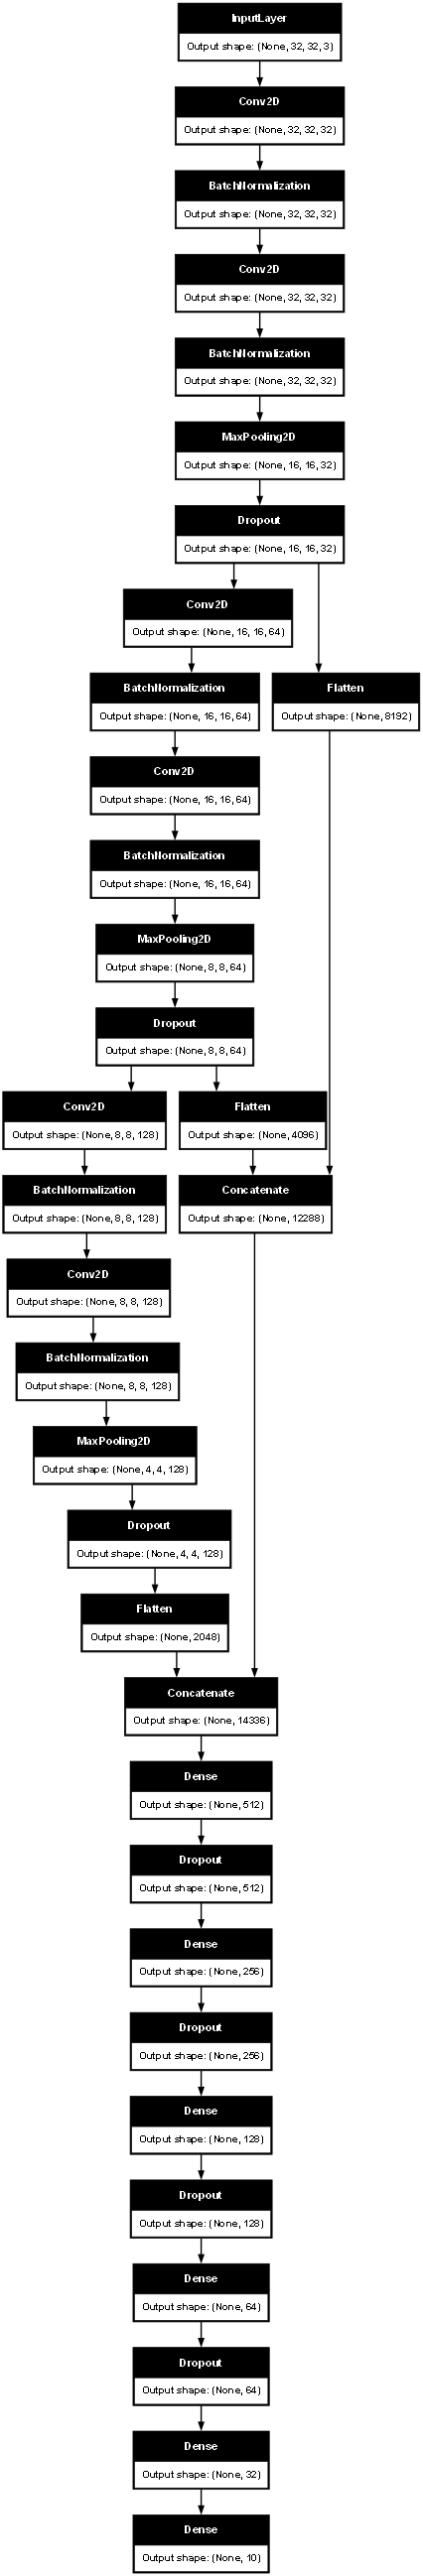

In [70]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [71]:
#Cambiamos el Optimizador a AdamW
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics, jit_compile=True)

In [72]:
#Early Stopping
my_callbacks = [
    keras.callbacks.EarlyStopping( 
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [73]:
# Hiperparámetros
batch_size = 128
epochs = 200
validation_split = 0.2

In [74]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 242s 737ms/step - accuracy: 0.2336 - loss: 2.6678 - val_accuracy: 0.3053 - val_loss: 1.8426
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 222s 707ms/step - accuracy: 0.4773 - loss: 1.4519 - val_accuracy: 0.5798 - val_loss: 1.2226
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 218s 697ms/step - accuracy: 0.5940 - loss: 1.1623 - val_accuracy: 0.6585 - val_loss: 1.0026
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 216s 690ms/step - accuracy: 0.6759 - loss: 0.9561 - val_accuracy: 0.7096 - val_loss: 0.8655
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 216s 688ms/step - accuracy: 0.7304 - loss: 0.7980 - val_accuracy: 0.7324 - val_loss: 0.8253
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 216s 690ms/step - accuracy: 0.7722 - loss: 0.6776 - val_accuracy: 0.7550 - val_loss: 0.7711
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 216s 690ms/step - accuracy: 0.8069 - loss: 0.5737 - val_accuracy: 0.7379 - val_loss: 0.8781
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 219s 699ms/step - accuracy: 

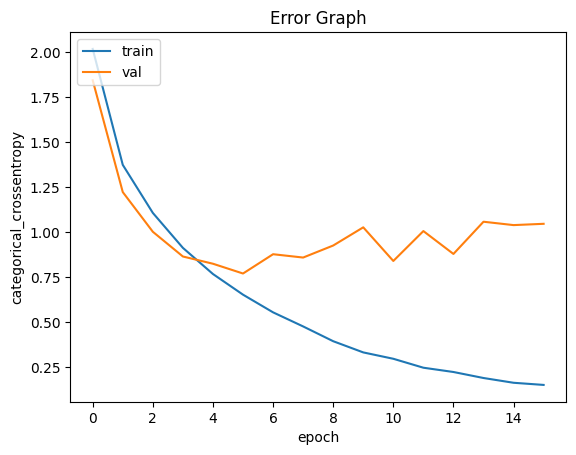

In [75]:
plot_losses(history, loss)

In [76]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.8011230230331421
Test accuracy: 0.7458000183105469


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


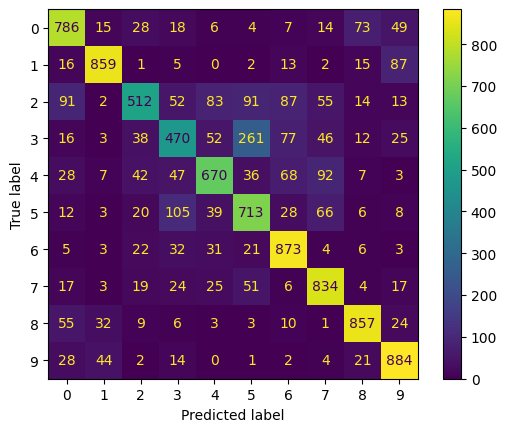

In [77]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [78]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.75      0.79      0.77      1000
     class 1       0.88      0.86      0.87      1000
     class 2       0.74      0.51      0.60      1000
     class 3       0.61      0.47      0.53      1000
     class 4       0.74      0.67      0.70      1000
     class 5       0.60      0.71      0.65      1000
     class 6       0.75      0.87      0.80      1000
     class 7       0.75      0.83      0.79      1000
     class 8       0.84      0.86      0.85      1000
     class 9       0.79      0.88      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.74      0.75      0.74     10000
weighted avg       0.74      0.75      0.74     10000



Ahora ya tenemos resultados aceptables, pero esta no es la única forma de mejorar nuestro modelo, si ya conocemos alguna arquitectura del estado del arte para nuestra tarea podemos simplemente importar un modelo, congelarlo y reemplazar la última capa para que se ajuste a nuestro problema. Esto se llama `Transfer Learning` y es una de las formas más usadas para entrenar redes neuronales en la actualidad, ya que nos ahorra mucho tiempo de entrenamiento y nos permite usar modelos que ya han sido probados y que sabemos que funcionan bien.

### 1.2.4 Transfer Learning

In [31]:
pre_trained_mobilenet = keras.applications.VGG16(input_shape=input_shape,include_top=False) #Cargamos la red pre-entrenada, sin la capa densa final, ya que queremos adaptar esta red a nuestro dataset.

#Agregamos una capa de GlobalAveragePooling2D para reducir la dimensionalidad de la salida de la red pre-entrenada y la capa de salida.
x = pre_trained_mobilenet.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=pre_trained_mobilenet.input, outputs=outputs)

for layer in pre_trained_mobilenet.layers: #Tenemos que explicitar que no queremos entrenar las capas de la red pre-entrenada.
    layer.trainable = False

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)        │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d_1      │ (None, 512)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 10)                │      5,130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,719,818 (449.21 MB)

 Trainable params: 5,130 (160.31 KB)

 Non-trainable params: 14,714,688 (449.06 MB)

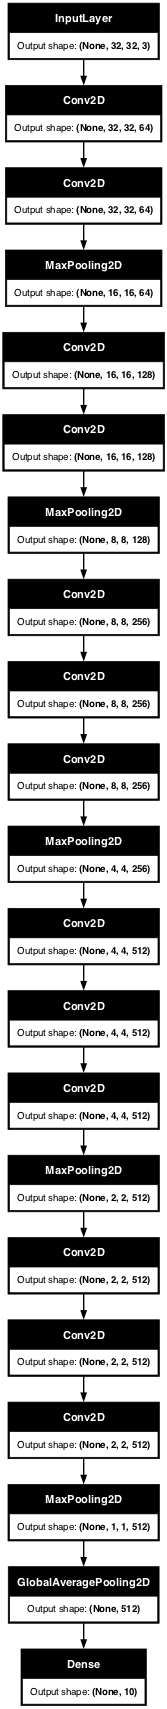

In [32]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

In [34]:
#Cambiamos el Optimizador
loss= keras.losses.CategoricalCrossentropy()
optimizer= keras.optimizers.AdamW(learning_rate=1e-3)
metrics=["accuracy"]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [35]:
#Entrenamos nuestro modelo
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=validation_split,
                    verbose=1,
                    callbacks=my_callbacks
                    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.3100 - loss: 12.5331 - val_accuracy: 0.4681 - val_loss: 4.3283
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5020 - loss: 3.4744 - val_accuracy: 0.5235 - val_loss: 2.4249
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5467 - loss: 2.0005 - val_accuracy: 0.5444 - val_loss: 1.7735
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5644 - loss: 1.5181 - val_accuracy: 0.5489 - val_loss: 1.5416
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5716 - loss: 1.3867 - val_accuracy: 0.5464 - val_loss: 1.4858
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5726 - loss: 1.3584 - val_accuracy: 0.5478 - val_loss: 1.4706
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5708 - loss: 1.3541 - val_accuracy: 0.5473 - val_loss: 1.4692
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5700 - loss: 

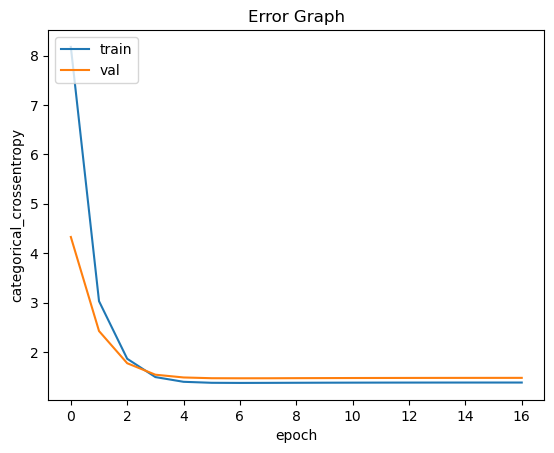

In [36]:
plot_losses(history, loss)

In [37]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.4544460773468018
Test accuracy: 0.5475999712944031


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


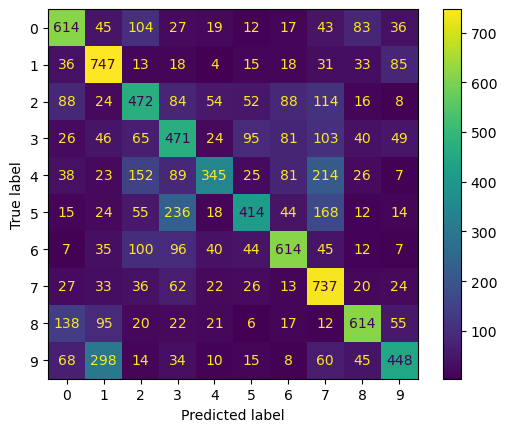

In [38]:
y_pred = model.predict(x_test)

plot_cm(y_pred, y_test)

In [39]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.58      0.61      0.60      1000
     class 1       0.55      0.75      0.63      1000
     class 2       0.46      0.47      0.46      1000
     class 3       0.41      0.47      0.44      1000
     class 4       0.62      0.34      0.44      1000
     class 5       0.59      0.41      0.49      1000
     class 6       0.63      0.61      0.62      1000
     class 7       0.48      0.74      0.58      1000
     class 8       0.68      0.61      0.65      1000
     class 9       0.61      0.45      0.52      1000

    accuracy                           0.55     10000
   macro avg       0.56      0.55      0.54     10000
weighted avg       0.56      0.55      0.54     10000



Podemos observar cómo no obtenemos resultados tan buenos como la red anterior pero hay que tener en cuenta que implementamos una arquitectura en menos de 5 lineas, desde cargar el modelo, agregar una capa de max pooling y finalmente la capa de salida.

## Parte 2: Datset Guiado

### 2.1 Exploracion de la Data

In [105]:
df = pd.read_csv('Steel_industry_data.csv')

In [15]:
df.head(10)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load
5,01/01/2018 01:30,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday,Light_Load
6,01/01/2018 01:45,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday,Light_Load
7,01/01/2018 02:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday,Light_Load
8,01/01/2018 02:15,3.28,3.64,0.0,0.0,66.94,100.0,8100,Weekday,Monday,Light_Load
9,01/01/2018 02:30,3.78,4.72,0.0,0.0,62.51,100.0,9000,Weekday,Monday,Light_Load


Siempre es bueno revisar los datos que tenemos, ver si existen datos faltantes, el tipo de dato de cada columna, etc.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

**Realice un pequeño EDA (Exploratory Data Analisys) del Dataset, mostrando algunos gráficos como el que se presenta a continuación, y comente lo que observa. [3pts]**

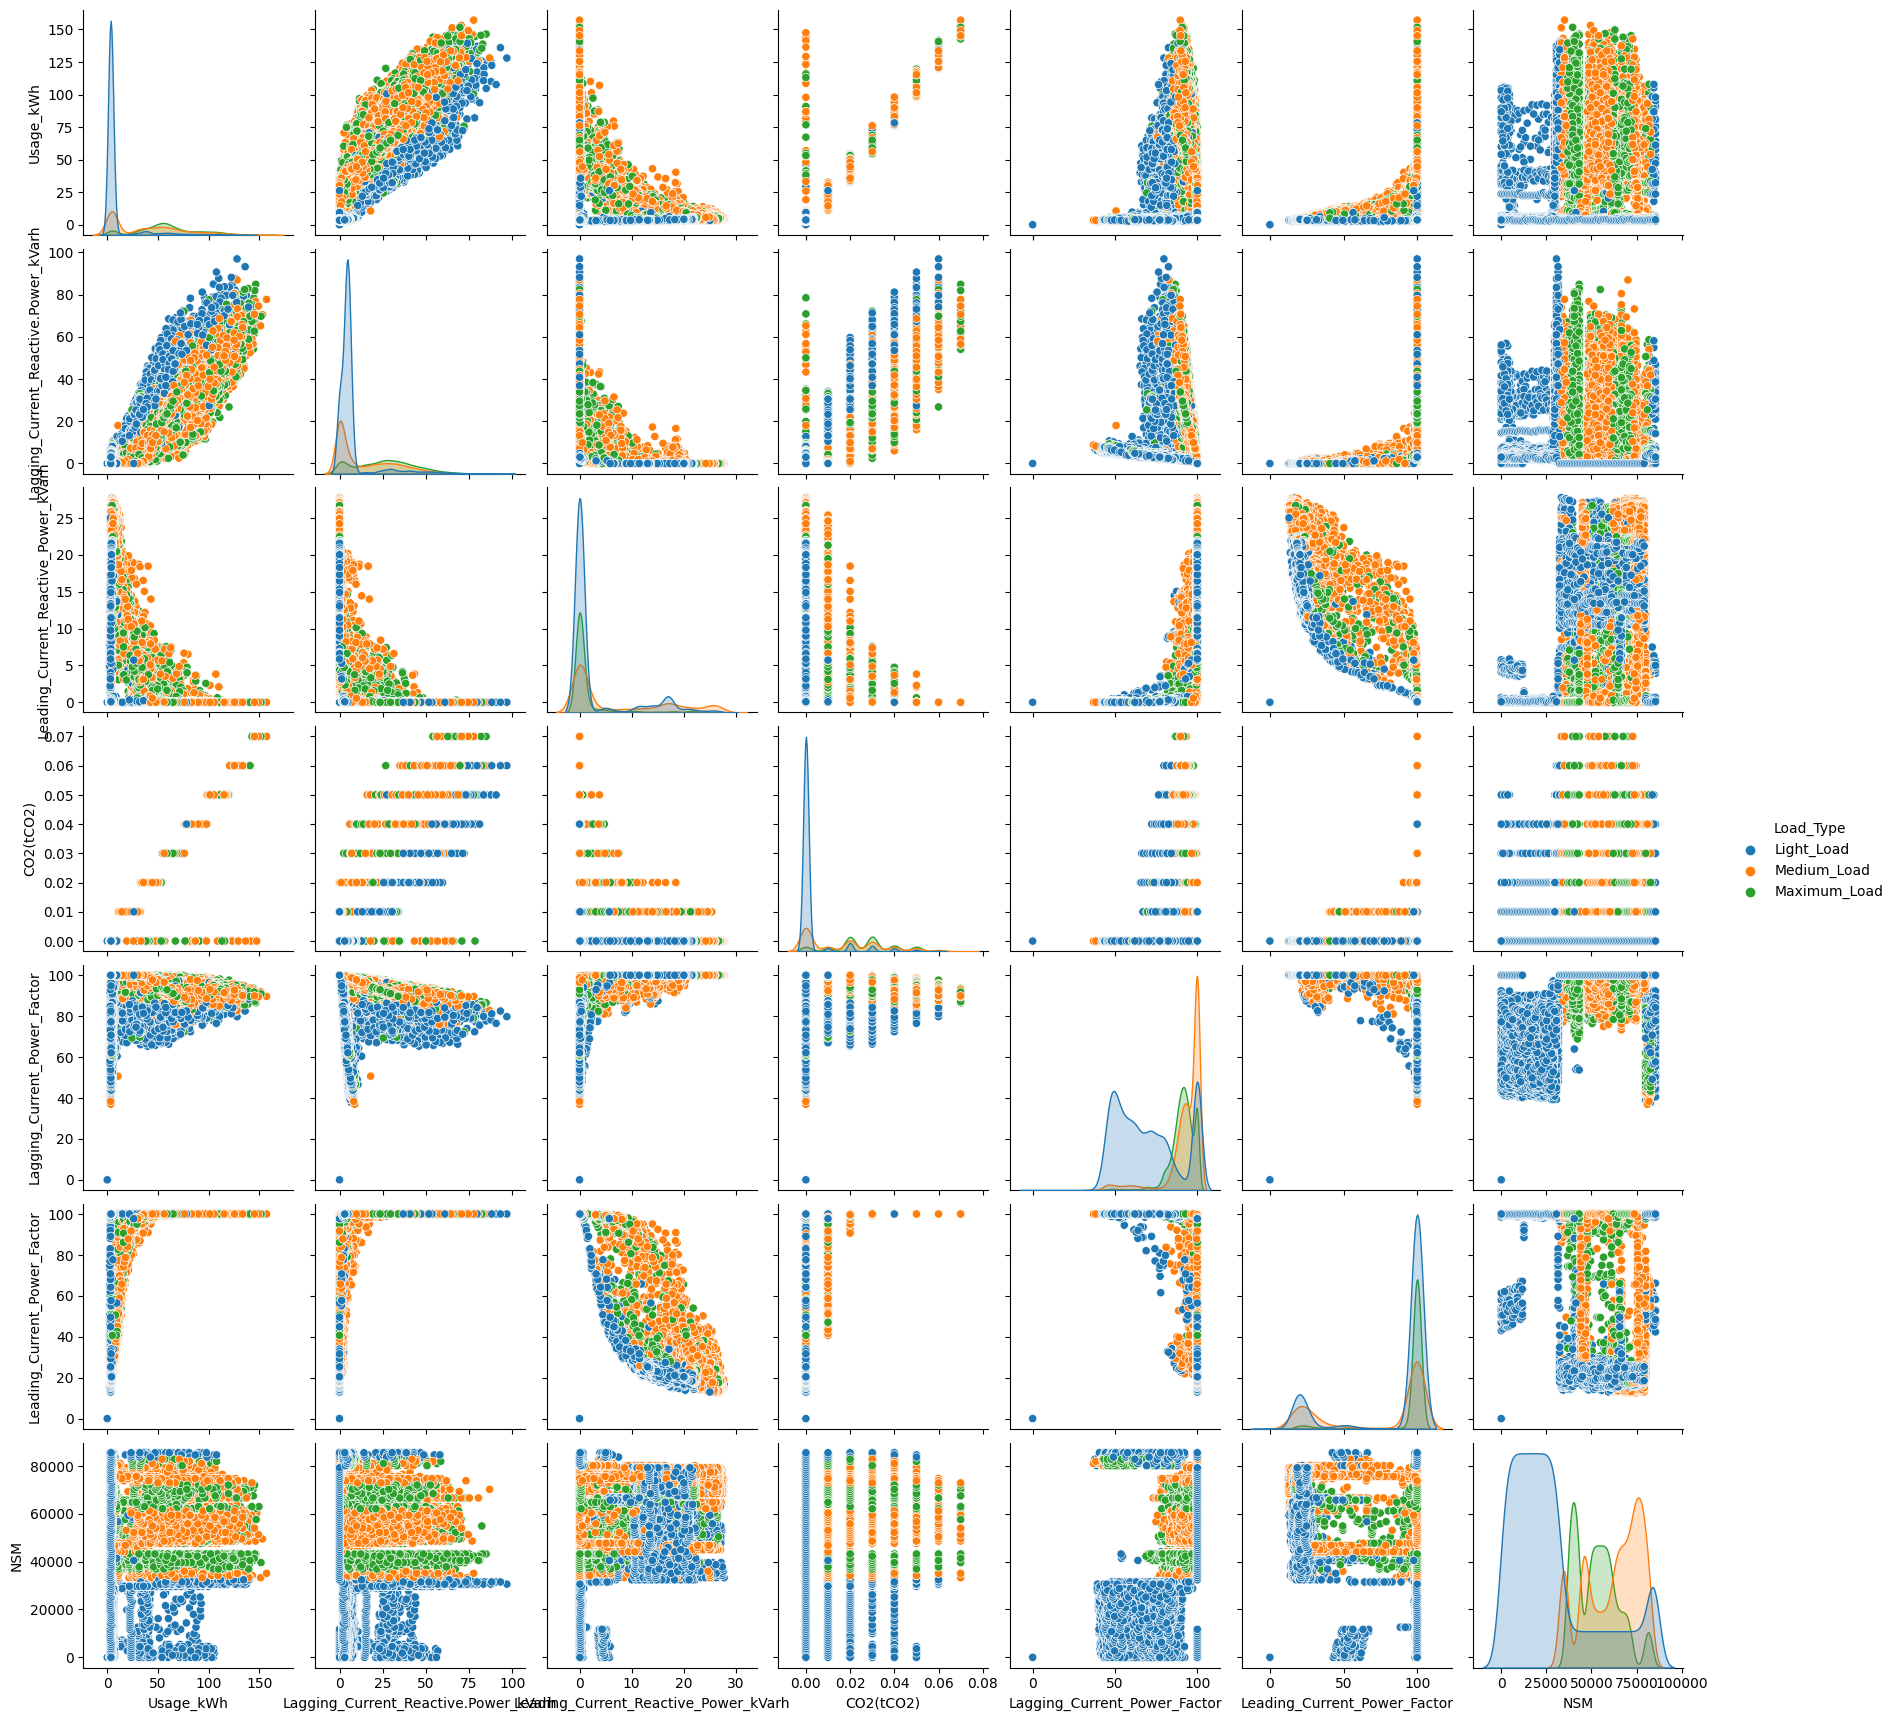

In [18]:
sns.pairplot(df, hue='Load_Type')

In [17]:
#Gráficos del EDA

import numpy as np
import matplotlib.pyplot as plt

def plot(c,d,e):
    classes=list(set(df[e]))
    colour=['#759109','#097591','#910975']
    for i in enumerate(classes):
        a=c
        b=d
        plt.scatter(df[a][(df.Load_Type == i[1])],
                    df[b][(df.Load_Type == i[1])],
                marker='D',
                color=colour[i[0]],
                label=i[1], s=20 , edgecolor="white", linewidth=0.5)

    plt.xlabel(a)
    plt.ylabel(b)
    plt.legend( loc=(1.05, 0) )
    plt.show()


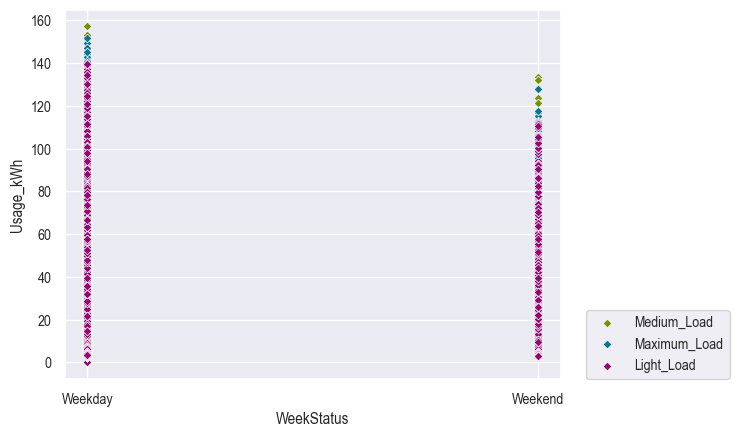

In [45]:
plot("WeekStatus","Usage_kWh","Load_Type")

**Observación**: El gráfico anterior da cuenta de que los días de mayor carga son en la semana, alcanzando peaks más altos durante el día. Esto tiene sentido al considerar que en la semana funciona la mayor parte de la industria y el comercio, mientras que el fin de semana suele ser más de reposo.

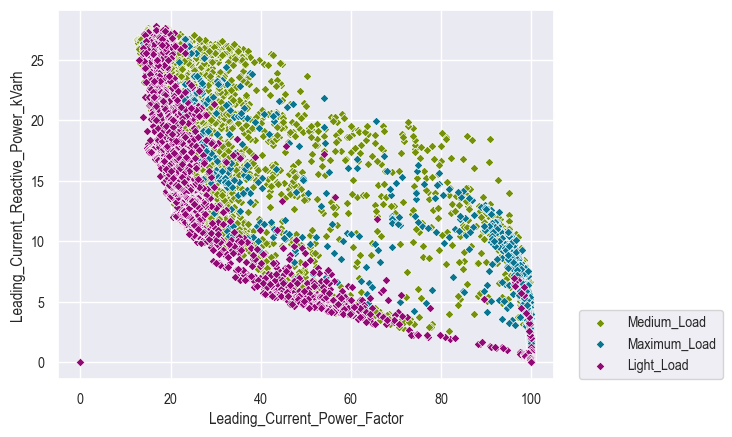

In [46]:
plot("Leading_Current_Power_Factor","Leading_Current_Reactive_Power_kVarh","Load_Type")

**Observación**: El gráfico anterior da cuenta de que las variables Leading_Current_Power_Factor y Leading_Current_Reactive_Power_kVarh siguen una relación inversa. Inclusive para demanda baja parece seguir una relación 1/x.

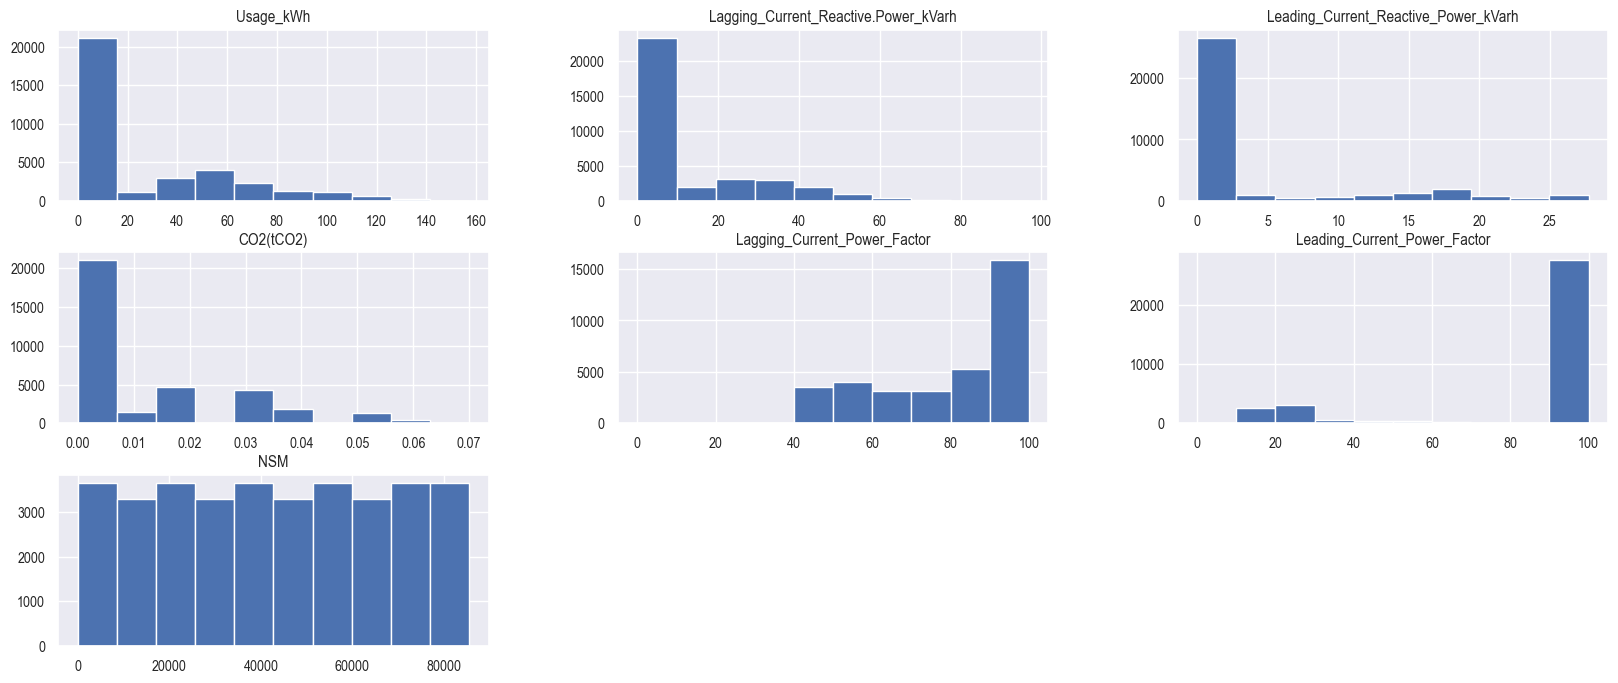

In [39]:
sns.set(style="darkgrid")
df.hist(figsize = (20,8))
plt.show()

**Observación**: Se puede apreciar la distribución de los datos.


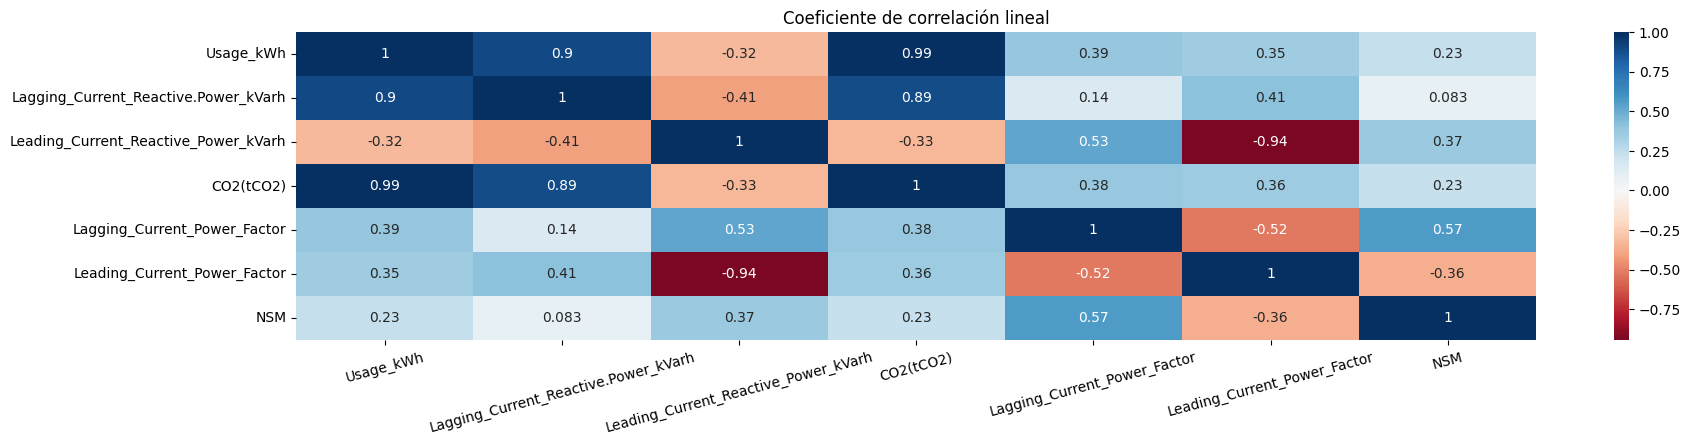

In [35]:
col = np.array([ 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM'])
corr = df[col].corr() # Correlación entre los datos
plt.figure(figsize = (20,4))
ax = sns.heatmap(corr, annot = True, center=0, cmap="RdBu")
ax.set(title='Coeficiente de correlación lineal')
ax.set_xticklabels(col, rotation=15)
plt.show()

**Observación:** La tabla superior expone los coeficientes de correlación lineal entre cada una de las categorías numéricas del dataset, con lo cual es posible conocer el grado de relación lineal que poseen cada una de las variables del problema. Así, se aprecia que son más las variables que no presentan correlación lineal que aquellas que si poseen.

### 2.2 Preprocesamiento

El proceso típico de entrenamiento de un modelo consta de dividir la data en 3 conjuntos, uno para entrenamiento, otro para validación y otro para testing

**Defina cuál es la utilidad de cada uno de estos conjuntos e implemente el código para separar la data considerando un split de 80/10/10 respectivamente** [3 Pts]

*80% de la data para entrenamiento, 10% para validación y el 10% para testing*

*Para ello se puede apoyar en la función [train_test_split](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) de scikit-learn.*

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size="size_for_test", random_state=SEED)
```
```
# Using a pandas dataframe
df_train, df_test = train_test_split(df_data, test_size="size_for_test", random_state=SEED)
```

In [47]:
### START CODE HERE ###

import sklearn
from sklearn.model_selection import train_test_split

df_train,df_test = train_test_split(df, test_size=0.1, random_state=SEED)
df_train,df_val= train_test_split(df_train, test_size=1/9, random_state=SEED)

In [48]:
df_train.shape, df_test.shape, df_val.shape, df.shape

((28032, 11), (3504, 11), (3504, 11), (35040, 11))



*   `Training`: Conjunto de datos que se utiliza para el entrenamiento del modelo. Con estos datos es posible obtener los parámetros (pesos y biases) con los cuales el modelo podrá predecir.
*   `Validation`: Conjunto de datos utilizado para determinar los hiper-parámetros del modelo, es decir, aquellos que no pueden ser calculados vía entrenamiento, sino que deben ser definidos a priori por la persona usuaria.
*   `Testing`: Conjunto de datos utilizado para determinar el desempeño del modelo en cuestión, con sus parámetros e hiper-parámetros ya definidos.



### 2.3 Feature Engineering

Feature Engineering se considera un arte porque involucra mucho la creatividad con el conocimiento del dominio del problema. Consiste en el proceso de crear nuevas características o features a partir de otras existentes. En general la idea principal es la de utilizar el conocimiento del contexto del problema o bien del dominio de los datos para aprovechar esa información y crear features que puedan ayudar en el desempeño de un algoritmo, si bien existen técnicas más o menos estándar como lo puede ser normalizar o estandarizar valores numéricos tambien existen otras transformaciones que no son tan simples y varían mucho dependiendo del problema.

[Referencia](https://elitedatascience.com/feature-engineering)

#### Standard Techniques

Como se ha mencionado anteriormente existen técnicas bastante conocidas en la actualidad para abordar el apartado de Feature Engineer donde la mayoría de estas se pueden dividir en dos grandes grupos dependiendo del tipo de datos tengamos:

1.   Variables numéricas
2.   Variables categóricas

#### Numerical values

*   Normalizing: `MinMaxScaler `
*   Standarizing: `StandardScaler`

#### Categorical values

*   `One-Hot Encoding.`
*   `Ordinal Encoding.`
*   `Label Encoding.`





**Observe el siguiente código y comente cuál podría ser su utilidad para una variable relacionada con fechas, como lo puede ser un día** [2 Pts]

In [106]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    #df.drop([column], axis=1, inplace=True)
    return df

In [12]:
# Crear un dataframe de muestra y aplicar la función
df_day = pd.DataFrame(data=np.arange(1, 366), columns=["day"])
df_day = preprocess_time(df_day, "day", 365)
df_day.head()

,day,sin_day,cos_day
0,1,0.017213,0.999852
1,2,0.034422,0.999407
2,3,0.051620,0.998667
3,4,0.068802,0.997630
4,5,0.085965,0.996298


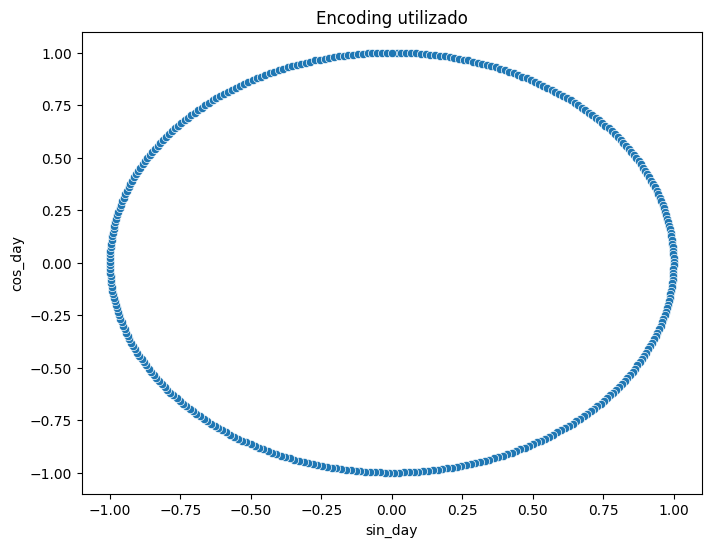

In [302]:
# Mostrar la transformación aplicada
fig = plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_day, x="sin_day", y="cos_day").set_title("Encoding utilizado")

plt.show()

`Respuesta`: El encoding utilizado para las fechas puede ser de utilidad para definir los días de un año dentro de una circunferencia de radio unitario. En este sentido, se escala la fecha e incluye el efecto periódico. De esta forma, puede ser un input de entrenamiento.

**Defina o explique la transformación que aplica cada uno de los siguientes encoding e indique la diferencia entre ellos considerando sklearn** [3 Pts]




*   `One-Hot Encoding`: Este tipo de encoding se utiliza para clases que no tengan relaciones ordinales. Consiste en crear columnas binarias para cada clase, definiendo '1' la columna correspondiente al valor presente en cada registro, dejando las demás columnas con un valor de '0'. Así, cada registro se representa por un vector binario que indica la presencia o ausencia de cada valor categórico, evitando la posibilidad de la malinterpretación de los algoritmos. Sin embargo, aumenta el número de dimensiones del conjunto de datos.

*   `Ordinal Encoding`: En este tipo de encoding, a cada clase se le asigna un valor entero único y que captura la relación ordinal entre las clases. Está el ejemplo de {Bajo, Medio, Alto} que el Ordinal Encoding transformaría en {1,2,3}.

*   `Label Encoding`: Este tipo de técnica se utiliza para convertir una variable categórica a una numérica. Sin embargo, presenta la limitación de que los algoritmos de ML pueden malinterpretar este encoding. Existe el ejemplo de 4 ciudades codificadas como {1,2,3,4} donde es posible que el algoritmo interprete a la ciudad '3' como un valor 3 veces mayor que la ciudad '1'.

**Aplique las siguientes técnicas de preprocesamiento para cada feature especificado:** [3 Pts]

*   `MinMaxScaler` con rango (0, 1): `CO2(tCO2)`, `NSM`
*   `StandardScaler`: `Lagging_Current_Reactive.Power_kVarh`, `Leading_Current_Reactive_Power_kVarh`, `Lagging_Current_Power_Factor`, `Leading_Current_Power_Factor`
*   `Ordinal Encoding`: `Load_Type`
*   `One-Hot Encoding`: `WeekStatus`
*   `Label Encoding`: `Day_of_week`

Por último separe en `dia`, `mes` y `hora` la columna `date` y aplique la transformación cíclica a las nuevas columnas (con el periodo correspondiente para cada una).

In [ ]:
# preprocesamiendo indicado
### START CODE HERE ###

#### MinMaxScaler
`MinMaxScaler` con rango (0, 1): `CO2(tCO2)`, `NSM`

In [107]:
from sklearn.preprocessing import MinMaxScaler
def minmax(c):
    scaler = MinMaxScaler()
    a=np.array(df[c]).reshape(-1,1)
    b=scaler.fit(a)
    print(scaler.data_min_,scaler.data_max_)
    #plot(c,c,'Load_Type')
    tr=pd.DataFrame(scaler.transform(a))
    plt.scatter(tr,tr)
    return tr
    


[0.] [0.07]


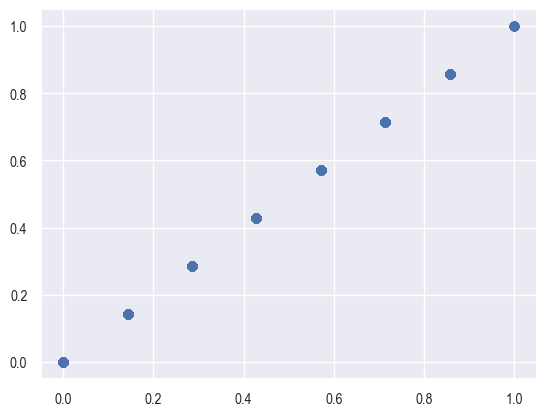

In [108]:
co=minmax('CO2(tCO2)')
df['CO2(tCO2)']=co

[0.] [85500.]


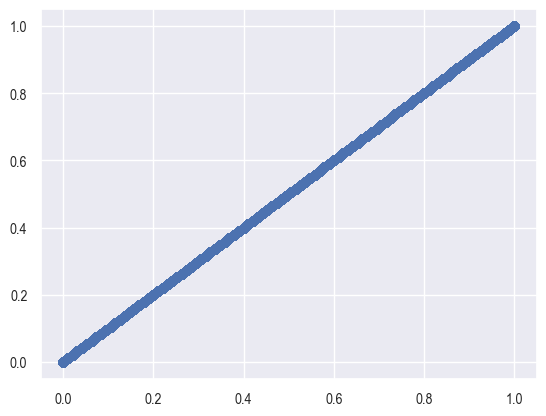

In [109]:
nsm=minmax('NSM')
df['NSM']=nsm

#### Standard scaler
`StandardScaler`: `Lagging_Current_Reactive.Power_kVarh`, `Leading_Current_Reactive_Power_kVarh`, `Lagging_Current_Power_Factor`, `Leading_Current_Power_Factor`

In [110]:
from sklearn.preprocessing import StandardScaler

def standard(d):
    scaler = StandardScaler()
    c=d
    a=np.array(df[c]).reshape(-1,1)
    b=scaler.fit(a)
    print(scaler.mean_)
    #plot(c,c,'Load_Type')
    tr=pd.DataFrame(scaler.transform(a))
    plt.scatter(tr,tr)
    return tr

##### Lagging_Current_Reactive.Power_kVarh

[13.03538356]


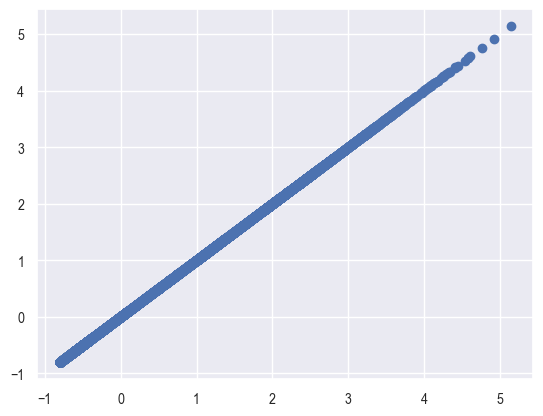

In [111]:
lgcrpv=standard('Lagging_Current_Reactive.Power_kVarh')

df['Lagging_Current_Reactive.Power_kVarh']=lgcrpv


Comprobando con una función fuera de scikit-learn

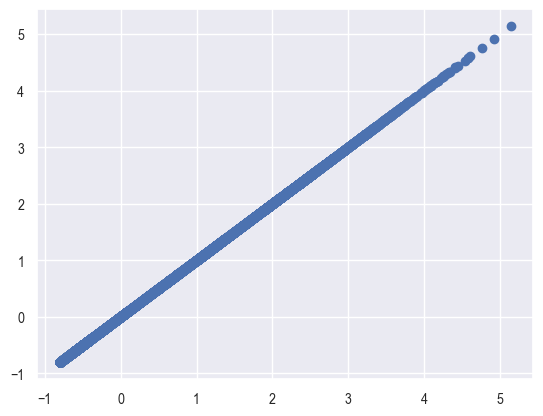

In [112]:
def st(d):
    a=df[d]
    mean=np.mean(df[d])
    std=np.std(df[d])
    st=(a-mean)/std
    return st


plt.scatter(st('Lagging_Current_Reactive.Power_kVarh'),st('Lagging_Current_Reactive.Power_kVarh'))

##### Lagging_Current_Power_Factor

[-4.80184132e-16]


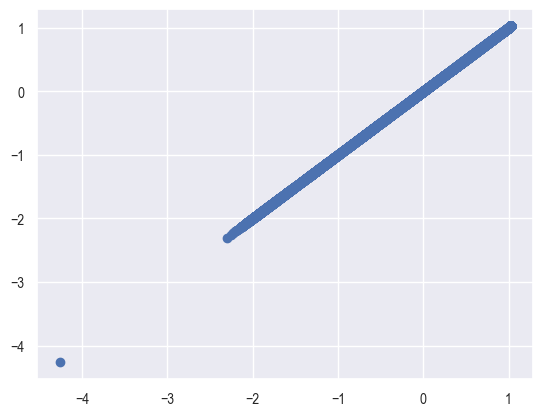

In [114]:
lcpw=standard('Lagging_Current_Power_Factor')
df[ 'Lagging_Current_Power_Factor'] = lcpw

##### Leading_Current_Reactive_Power_kVarh

[3.87094863]


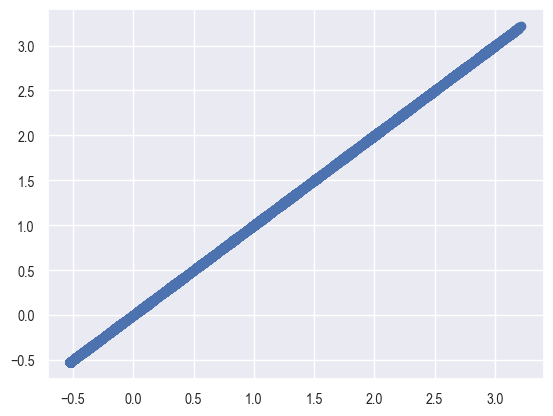

In [115]:
ldcrpk=standard('Leading_Current_Reactive_Power_kVarh')
df['Leading_Current_Reactive_Power_kVarh' ]=ldcrpk

##### Leading_Current_Power_Factor

[84.36786986]


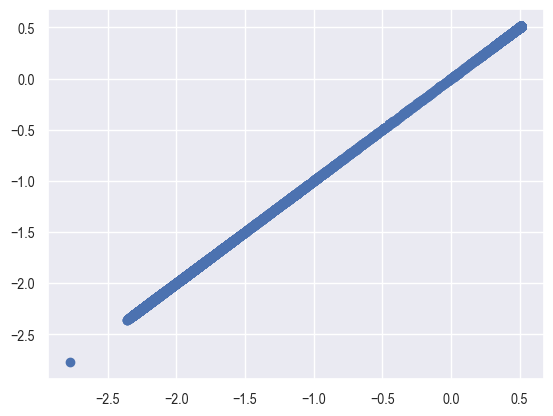

In [116]:
ldcpf=standard('Leading_Current_Power_Factor')
df['Leading_Current_Power_Factor' ]=ldcpf

#### Ordinal Encoding
`Load_Type`

In [117]:
classes=[list(df['Load_Type'].unique())]
classes1=np.array(classes).reshape(-1,1)
classes


[['Light_Load', 'Medium_Load', 'Maximum_Load']]

In [118]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=classes)
OrdinalEncoder()

df['Load_Type']=enc.fit_transform(df[['Load_Type']])

array([[<Axes: title={'center': 'Load_Type'}>]], dtype=object)

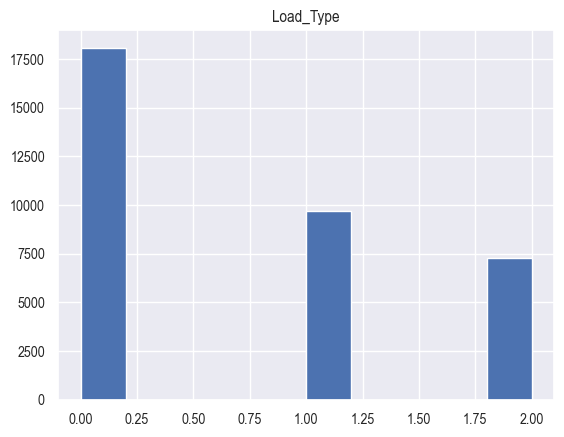

In [119]:
df[['Load_Type']].hist()

#### One-Hot Encoding
`WeekStatus`

In [120]:
clases=np.array(df['WeekStatus']).reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(clases)

a=enc.transform(clases).toarray()
b=enc.inverse_transform(a)

print(a.shape, b.shape)
print(b)
print(a)

enc.categories_


(35040, 2) (35040, 1)
[['Weekday']
 ['Weekday']
 ['Weekday']
 ...
 ['Weekday']
 ['Weekday']
 ['Weekday']]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


[array(['Weekday', 'Weekend'], dtype=object)]

In [121]:
ws=pd.DataFrame(enc.transform(np.array(df['WeekStatus']).reshape(-1,1)).toarray())
ws.columns=['WeekStatus_0','WeekStatus_1']

df=df.drop('WeekStatus',axis=1)
df=df.join([ws])

#### Label Encoding
`Day_of_week`

In [122]:
i = 0
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for val in df['Day_of_week'].values:
    if val == labels[0]:
        df['Day_of_week'].values[i] = 0
    if val == labels[1]:
        df['Day_of_week'].values[i] = 1
    if val == labels[2]:
        df['Day_of_week'].values[i] = 2
    if val == labels[3]:
        df['Day_of_week'].values[i] = 3
    if val == labels[4]:
        df['Day_of_week'].values[i] = 4
    if val == labels[5]:
        df['Day_of_week'].values[i] = 5
    if val == labels[6]:
        df['Day_of_week'].values[i] = 6
    i+=1

#### Date
Por último separe en `dia`, `mes` y `hora` la columna `date` y aplique la transformación cíclica a las nuevas columnas (con el periodo correspondiente para cada una).

In [125]:
fech = pd.DataFrame()
fech['date']= pd.to_datetime(df['date'],format="%d/%m/%Y %H:%M" )
fech["day"] = fech['date'].dt.day
fech["month"] = fech['date'].dt.month
fech["year"] = fech['date'].dt.year
fech["hour"] = fech['date'].dt.strftime("%H:%M")

fech

,date,day,month,year,hour
0,2018-01-01 00:15:00,1,1,2018,00:15
1,2018-01-01 00:30:00,1,1,2018,00:30
2,2018-01-01 00:45:00,1,1,2018,00:45
3,2018-01-01 01:00:00,1,1,2018,01:00
4,2018-01-01 01:15:00,1,1,2018,01:15
...,...,...,...,...,...
35035,2018-12-31 23:00:00,31,12,2018,23:00
35036,2018-12-31 23:15:00,31,12,2018,23:15
35037,2018-12-31 23:30:00,31,12,2018,23:30
35038,2018-12-31 23:45:00,31,12,2018,23:45


In [130]:
fech['Usage_kWh']=df['Usage_kWh']

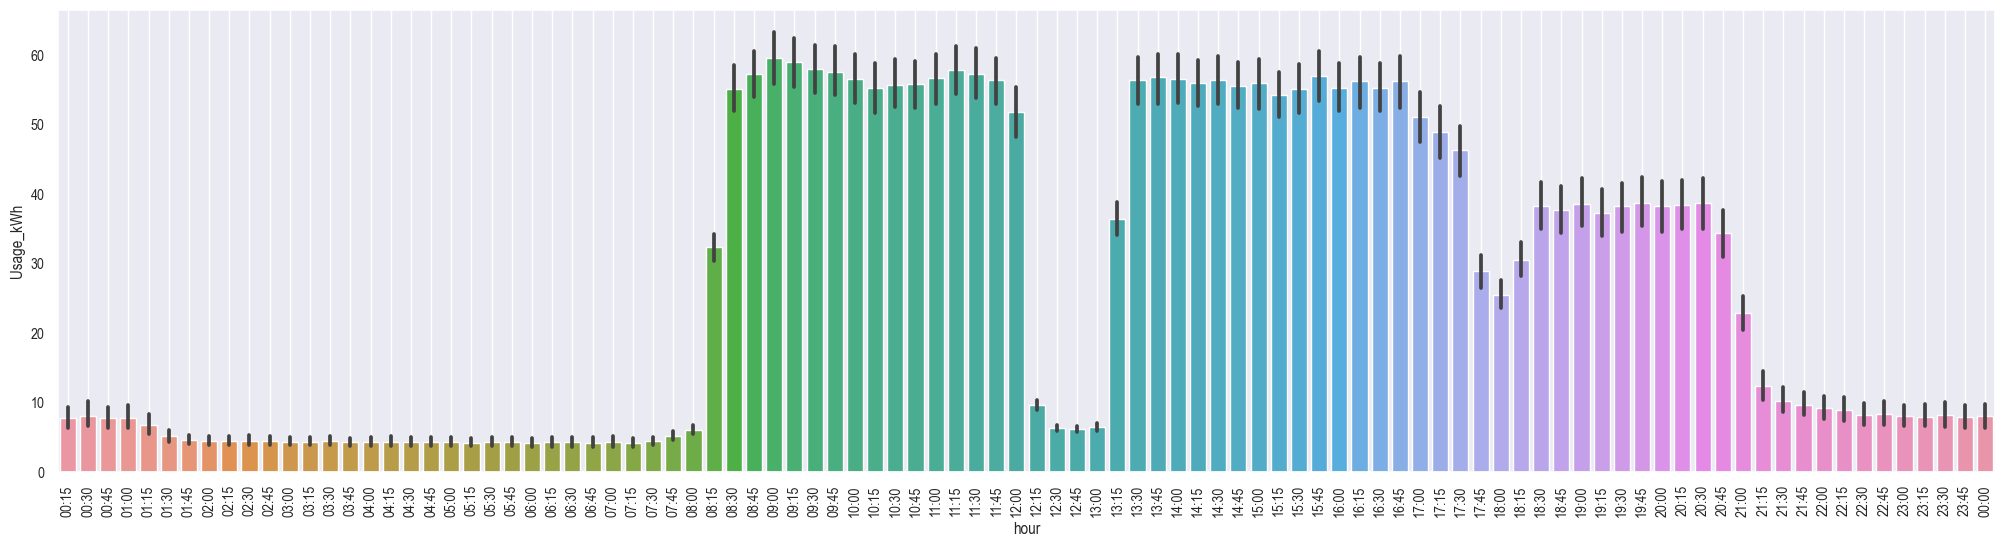

In [147]:
plt.figure(figsize = (25, 6))
ax = sns.barplot(x='hour', y='Usage_kWh', data=fech)
ax.set_xticklabels(fech['hour'].unique(), rotation=90)
plt.grid()
plt.show()

In [148]:
def fecha(d,t,e):
    c=fech
    e = preprocess_time(c, d, t)
    e.head()
    # Mostrar la transformación aplicada
    fig = plt.figure(figsize=(8, 6))
    sns.scatterplot(data=e, x="sin_"+d, y="cos_"+d).set_title("Encoding utilizado con" + d)
    plt.show()
    return e


##### Day

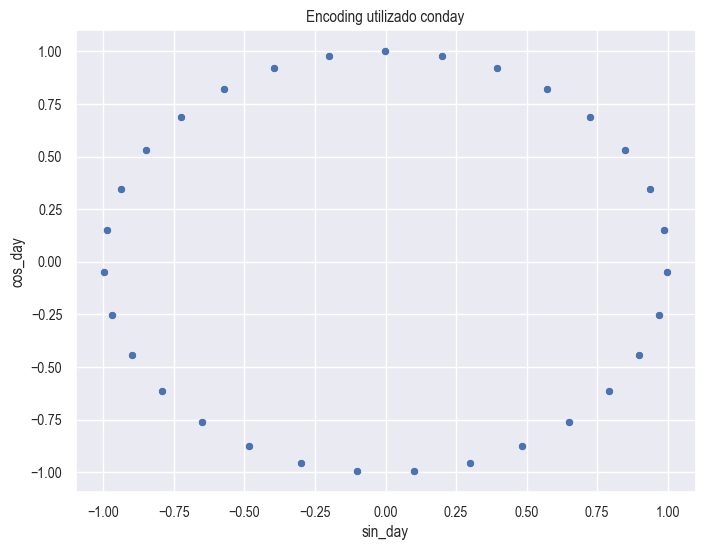

In [149]:
e=fecha('day',31,df)


##### Month

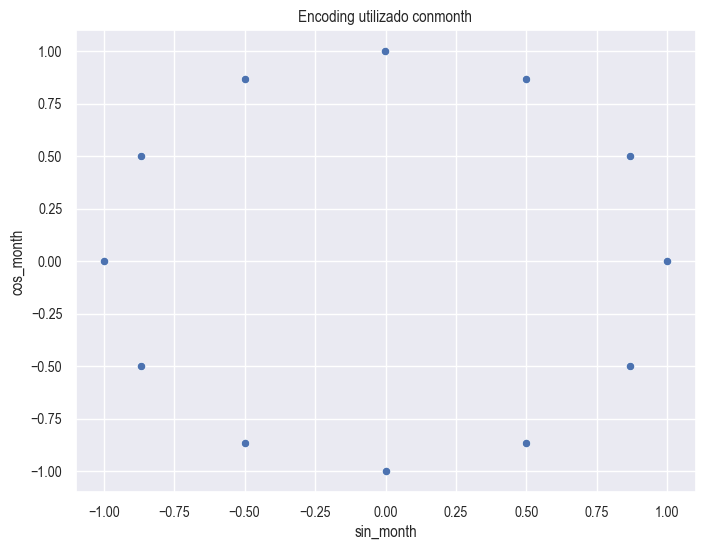

In [150]:
e=fecha('month',12,df)

In [156]:
e=e.drop('date',axis=1)
e=e.drop('Usage_kWh',axis=1)
df=df.drop('date',axis=1)
df=df.join(e[e.columns[4:]])

##### Hour

In [164]:
aux = pd.DataFrame(data=np.arange(1, 97), columns=["hour"])
aux = preprocess_time(aux, "hour", 97)# 365)

df_h = pd.DataFrame()
flag = True
col, row = df_h.shape
while flag:
    if row < 35040:
        df_h = pd.concat([df_h, aux], axis=0, ignore_index=True)
        row, col = df_h.shape
    else:
        flag = False

df = pd.concat([df, df_h], axis=1)
df = df.drop(columns=['hour'])

In [165]:
df

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_0,WeekStatus_1,sin_day,cos_day,sin_month,cos_month,sin_hour,cos_hour,sin_hour,cos_hour
0,3.17,-0.618516,-0.521385,0.0,-0.389410,0.513268,0.010526,0,0.0,1.0,0.0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.064730,0.997903,0.064730,0.997903
1,4.00,-0.525911,-0.521385,0.0,-0.729772,0.513268,0.021053,0,0.0,1.0,0.0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.129188,0.991620,0.129188,0.991620
2,3.24,-0.598278,-0.521385,0.0,-0.544264,0.513268,0.031579,0,0.0,1.0,0.0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.193105,0.981178,0.193105,0.981178
3,3.31,-0.581106,-0.521385,0.0,-0.660009,0.513268,0.042105,0,0.0,1.0,0.0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.256211,0.966621,0.256211,0.966621
4,3.82,-0.523458,-0.521385,0.0,-0.838117,0.513268,0.052632,0,0.0,1.0,0.0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.318243,0.948009,0.318243,0.948009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,3.85,-0.501380,-0.521385,0.0,-0.976587,0.513268,0.968421,0,0.0,1.0,0.0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-0.318243,0.948009,-0.318243,0.948009
35036,3.74,-0.570067,-0.521385,0.0,-0.521538,0.513268,0.978947,0,0.0,1.0,0.0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-0.256211,0.966621,-0.256211,0.966621
35037,3.78,-0.605024,-0.511957,0.0,-0.209188,0.512611,0.989474,0,0.0,1.0,0.0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-0.193105,0.981178,-0.193105,0.981178
35038,3.78,-0.611770,-0.506569,0.0,-0.151052,0.511954,1.000000,0,0.0,1.0,0.0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-0.129188,0.991620,-0.129188,0.991620


### 2.4 Datos a predecir

Una vez teniendo nuestro dataset preprocesado toca crear un modelo de redes neuronales para predecir, para esto vamos a separar nuestro vector de entrada de la columna a predecir

In [166]:
df.head(100)

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_0,WeekStatus_1,sin_day,cos_day,sin_month,cos_month,sin_hour,cos_hour,sin_hour,cos_hour
0,3.17,-0.618516,-0.521385,0.0,-0.389410,0.513268,0.010526,0,0.0,1.0,0.0,0.201299,0.979530,0.5,0.866025,0.064730,0.997903,0.064730,0.997903
1,4.00,-0.525911,-0.521385,0.0,-0.729772,0.513268,0.021053,0,0.0,1.0,0.0,0.201299,0.979530,0.5,0.866025,0.129188,0.991620,0.129188,0.991620
2,3.24,-0.598278,-0.521385,0.0,-0.544264,0.513268,0.031579,0,0.0,1.0,0.0,0.201299,0.979530,0.5,0.866025,0.193105,0.981178,0.193105,0.981178
3,3.31,-0.581106,-0.521385,0.0,-0.660009,0.513268,0.042105,0,0.0,1.0,0.0,0.201299,0.979530,0.5,0.866025,0.256211,0.966621,0.256211,0.966621
4,3.82,-0.523458,-0.521385,0.0,-0.838117,0.513268,0.052632,0,0.0,1.0,0.0,0.201299,0.979530,0.5,0.866025,0.318243,0.948009,0.318243,0.948009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.42,-0.587239,-0.521385,0.0,-0.543207,0.513268,0.000000,0,0.0,1.0,0.0,0.201299,0.979530,0.5,0.866025,-0.064730,0.997903,-0.064730,0.997903
96,3.20,-0.609317,-0.521385,0.0,-0.462874,0.513268,0.010526,1,0.0,1.0,0.0,0.394356,0.918958,0.5,0.866025,0.064730,0.997903,0.064730,0.997903
97,3.85,-0.516712,-0.521385,0.0,-0.870885,0.513268,0.021053,1,0.0,1.0,0.0,0.394356,0.918958,0.5,0.866025,0.129188,0.991620,0.129188,0.991620
98,3.28,-0.574360,-0.521385,0.0,-0.736643,0.513268,0.031579,1,0.0,1.0,0.0,0.394356,0.918958,0.5,0.866025,0.193105,0.981178,0.193105,0.981178


In [167]:
# Separar la columna a predecir "Usage_kWh" y los datos para entrenar
### START CODE HERE ###
import torch
import random
from sklearn.model_selection import train_test_split

df_train,df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
y_train =  df_train ['Usage_kWh']
X_train = df_train[df_train.columns[1:]]

y_test = df_test ['Usage_kWh'] 
X_test = df_test[df_train.columns[1:]]


In [168]:
X_train.head(10)

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Load_Type,WeekStatus_0,WeekStatus_1,...,sin_month,cos_month,sin_hour,sin_hour,cos_hour,cos_hour,sin_hour,sin_hour,cos_hour,cos_hour
9284,-0.799434,2.412202,0.000000,1.026473,-2.151223,0.726316,5,1.0,0.0,1.0,...,8.660254e-01,-5.000000e-01,-0.970643,-0.970643,-0.240525,-0.240525,-0.970643,-0.970643,-0.240525,-0.240525
14314,-0.497087,-0.521385,0.000000,-1.565349,0.513268,0.115789,2,0.0,1.0,0.0,...,5.000000e-01,-8.660254e-01,0.653747,0.653747,0.756713,0.756713,0.653747,0.653747,0.756713,0.756713
5094,-0.349286,-0.521385,0.000000,-0.773110,0.513268,0.073684,4,0.0,1.0,0.0,...,8.660254e-01,5.000000e-01,0.438048,0.438048,0.898952,0.898952,0.438048,0.438048,0.898952,0.898952
33269,0.566954,-0.521385,0.428571,0.662857,0.513268,0.568421,3,1.0,1.0,0.0,...,-2.449294e-16,1.000000e+00,-0.348774,-0.348774,-0.937207,-0.937207,-0.348774,-0.348774,-0.937207,-0.937207
9994,-0.565161,-0.521385,0.000000,-0.928493,0.513268,0.115789,6,0.0,0.0,1.0,...,8.660254e-01,-5.000000e-01,0.653747,0.653747,0.756713,0.756713,0.653747,0.653747,0.756713,0.756713
19553,1.044086,-0.521385,0.428571,0.388559,0.513268,0.694737,0,2.0,1.0,0.0,...,-5.000000e-01,-8.660254e-01,-0.905927,-0.905927,-0.423433,-0.423433,-0.905927,-0.905927,-0.423433,-0.423433
8225,-0.563321,-0.478284,0.285714,0.998462,0.513268,0.694737,1,2.0,1.0,0.0,...,1.000000e+00,6.123234e-17,-0.905927,-0.905927,-0.423433,-0.423433,-0.905927,-0.905927,-0.423433,-0.423433
939,-0.799434,3.100478,0.000000,1.026473,-2.148925,0.800000,2,2.0,1.0,0.0,...,5.000000e-01,8.660254e-01,-0.977923,-0.977923,0.208968,0.208968,-0.977923,-0.977923,0.208968,0.208968
5252,-0.415521,-0.327429,0.428571,1.003747,0.512611,0.726316,5,2.0,0.0,1.0,...,8.660254e-01,5.000000e-01,-0.970643,-0.970643,-0.240525,-0.240525,-0.970643,-0.970643,-0.240525,-0.240525
11860,-0.247482,0.651781,0.142857,0.818239,0.391453,0.557895,4,2.0,1.0,0.0,...,5.000000e-01,-8.660254e-01,-0.287378,-0.287378,-0.957817,-0.957817,-0.287378,-0.287378,-0.957817,-0.957817


In [169]:
X_train.shape, y_train.shape

((28032, 22), (28032,))

### 2.5 Mi primera Red Neuronal

Ahora procederemos a crear nuestro modelo con Keras, aca queda a libre elección si quieren utilizar la API secuencial o funcional, y tambien queda a libre elección la arquitectura de la red, pruebe con distintas capas, distinto número de neuronas, distintas funciones de activación, regularizadores, etc.

In [203]:
#Crear un modelo de Keras a libre elección
### START CODE HERE ###
from tensorflow.keras import regularizers
from keras.regularizers import l1
l1 = 0.001

inputs = keras.layers.Input(shape=(X_train.shape[1],)) 
#x = keras.layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1(l1=l1))(inputs)
x = keras.layers.Dense(512, activation = 'relu', kernel_regularizer=regularizers.l1(l1=l1))(inputs)
#x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(256, activation = 'relu', kernel_regularizer=regularizers.l1(l1=l1))(x)
x = keras.layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1(l1=l1))(x)
#x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, activation = 'relu', kernel_regularizer=regularizers.l1(l1=l1))(x)
#x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(32, activation = 'relu', kernel_regularizer=regularizers.l1(l1=l1))(x)
x = keras.layers.Dense(8, activation = 'relu', kernel_regularizer=regularizers.l1(l1=l1))(x)
#x = keras.layers.Dropout(0.1)(x)
#x = keras.layers.BatchNormalization()(x)
#

output = keras.layers.Dense(1 ,activation = 'linear')(x)
model = keras.Model(inputs=inputs, outputs=output)

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 22)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_29 (Dense)                │ (None, 512)               │     11,776 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_30 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_31 (Dense)                │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_32 (Dense)                │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_33 (Dense)                │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_34 (Dense)                │ (None, 8)                 │        264 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_35 (Dense)                │ (None, 1)                 │          9 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 186,609 (728.94 KB)

 Trainable params: 186,609 (728.94 KB)

 Non-trainable params: 0 (0.00 B)

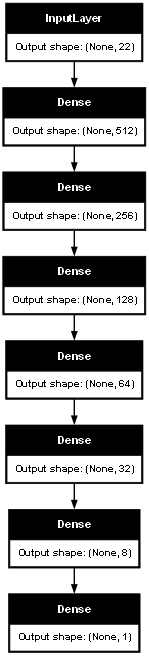

In [204]:
keras.utils.plot_model(model, show_shapes=True, rankdir="TB", dpi=50)

**Siendo un problema de regresión, ¿cuántas neuronas en la capa de salida tiene que tener nuestro modelo? y con que activación? [3pts]**

`Respuesta`: Debe tener una única neurona y la función de activación debe ser linear.

Ahora vamos a compilar y entrenar nuestro modelo, si quiere ponerse más creativo en esta sección puede implementar callbacks, probar distintos optimizadores, batch_size y epochs.

In [205]:
### START CODE HERE ###
loss = keras.losses.MeanSquaredError()
#loss= tf.keras.losses.SparseCategoricalCrossentropy()

#opt = keras.optimizers.SGD(learning_rate=1e-3)
opt = keras.optimizers.RMSprop(learning_rate=1e-3)
#opt = keras.optimizers.Adagrad(learning_rate=1e-3)
#opt = keras.optimizers.Adam()

metrics=["mean_squared_error", "mean_absolute_error", "root_mean_squared_error"]


model.compile(optimizer=opt, loss=loss, metrics=metrics)


#Early Stopping
my_callbacks = [keras.callbacks.EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=10,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )
]

In [206]:
### START CODE HERE ###
epochs = 200
batch_size = 128
val_split = 0.2
my_callbacks =  my_callbacks #si va a implementar early stopping, asegurese de retornar los mejores pesos

### 2.6 Entrenando el Modelo

In [207]:
### START CODE HERE ###

history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=val_split, 
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 459.8389 - mean_absolute_error: 10.7745 - mean_squared_error: 451.1812 - root_mean_squared_error: 19.7379 - val_loss: 65.2881 - val_mean_absolute_error: 4.1754 - val_mean_squared_error: 57.7913 - val_root_mean_squared_error: 7.6021
Epoch 2/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 42.6663 - mean_absolute_error: 3.2824 - mean_squared_error: 35.3961 - root_mean_squared_error: 5.9465 - val_loss: 41.1744 - val_mean_absolute_error: 3.2084 - val_mean_squared_error: 34.3234 - val_root_mean_squared_error: 5.8586
Epoch 3/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 32.0185 - mean_absolute_error: 2.8343 - mean_squared_error: 25.3792 - root_mean_squared_error: 5.0344 - val_loss: 22.3609 - val_mean_absolute_error: 2.1016 - val_mean_squared_error: 16.2536 - val_root_mean_squared_error: 4.0316
Epoch 4/200
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 29.6896 - mean_absolute_error: 2.6732 - mean_squared_error: 23.746

In [208]:
def plot_history(history):
    errs = [err for err in history.history.keys() if not 'val' in err]

    nc = len(errs)
    fig, axes = plt.subplots(ncols=nc, figsize=(min(12, 4 * nc), min(3, np.round(12 / nc))))
    fig.subplots_adjust(hspace=0.45, wspace=.45)
    
    for i, err in enumerate(errs):
        axes[i].plot(history.history[err], color='k', label='train')
        try:
            axes[i].plot(history.history[f'val_{err}'], color='r', label='val')
        except:
            pass
        axes[i].set_ylabel(err)
        axes[i].set_title(f'{err}')
        axes[i].set_yscale('log')
    plt.legend()
    fig.savefig("Plot_history_TFF.png")
    plt.show()

In [1]:
plot_losses(history, loss)

NameError: name 'plot_losses' is not defined

In [211]:
score = model.evaluate(X_test, y_test)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1500 - mean_absolute_error: 0.4925 - mean_squared_error: 1.0193 - root_mean_squared_error: 1.0084


In [212]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test, verbose=1)
R=float(r2_score(y_test,y_pred))
R

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


0.999088964544446

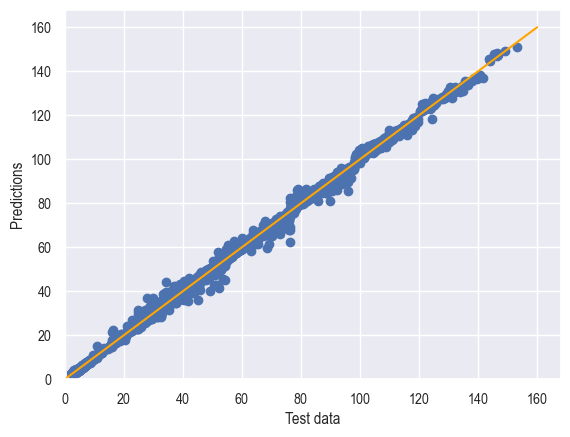

In [213]:
plt.plot(np.linspace(160, 0), np.linspace(160, 0), color='orange') 
plt.scatter(y_test, y_pred)
plt.xlabel('Test data')
plt.ylabel('Predictions')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.show()

### 2.7 Exportar y guardar el Modelo

Por último, una vez entrenado nuestro modelo es importante guardarlo, para esto utilizaremos la función `save_model` de keras

In [54]:
# model.save('steel_ind_regression.keras')

Para la entrega de la tarea, el modelo creado tiene que ser subido junto al jupyter notebook completado al github, ya sea en .keras o en un archivo .zip, el modelo será cargado y evaluado para comprobar su correcto funcionamiento, se recomienda probar el guardar y cargar el modelo en el mismo notebook para verificar que no hayan errores.